# Example using GeoProfile

In [1]:
import io

import matplotlib.pyplot as plt
import plotly
import plotly.io as pio
import pygef
from nuclei.client import NucleiClient
from shapely.geometry import LineString
from tqdm import tqdm

from geoprofile import Column, Section

Cell below gives a popup the enter the Nuclei token. You can get your token at: https://nuclei.cemsbv.io/.

In [2]:
client = NucleiClient()

In [3]:
pio.renderers.default = "browser"

In [4]:
author = "N. Uclei"
project_name = "Ter Aasseweg"
project_number = "2025"

In [5]:
# ** cpt_selection
# Specify a list of CPTs names (i.e. BRO ID).
cpt_selection = [
    "CPT000000018920",
    "CPT000000018949",
    "CPT000000018938",
    "CPT000000018927",
    "CPT000000018939",
    "CPT000000018928",
]

profile_line = LineString([[127667, 469200], [127661, 468215]])

In [6]:
# ** classify_metode:
# Metode used to classify CPT data.
# Accepted values: ["beenJefferies", "machineLearning", "nen", "table", "robertson", "ntype"]
classify_metode = "ntype"

In [7]:
# Get CPTs
# loop over the cpt id's and fetch file from BRO
cptdata_objects = []
for file_metadata in tqdm(cpt_selection, desc="Download CPT's from BRO"):
    # download CPT from BRO
    response = client.session.get(
        url=f"https://publiek.broservices.nl/sr/cpt/v1/objects/{file_metadata}"
    )
    if not response.ok:
        print(
            f"RuntimeError: {file_metadata} could not be downloaded from de BRO server. \n Status code: {response.status_code}"
        )
        continue

    cpt = pygef.read_cpt(io.BytesIO(response.content))
    object.__setattr__(cpt, "alias", file_metadata)
    object.__setattr__(cpt, "data", cpt.data.drop_nulls())
    cptdata_objects.append(cpt)

Download CPT's from BRO: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


CPTs are classified using CPTcore on Nuclei server. Requires that permissions are included in your token.

In [8]:
# create columns
columns = []
for gef in tqdm(cptdata_objects):

    # drop non-unique elements
    data = gef.data.unique(subset="penetrationLength", maintain_order=True)

    # create schema for cpt classification
    schema = {
        "aggregateLayersPenalty": 3,
        "data": {
            "coneResistance": data.get_column("coneResistance").clip(0, 1e10).to_list(),
            "correctedPenetrationLength": data.get_column(
                "penetrationLength"
            ).to_list(),
            "localFriction": data.get_column("localFriction").clip(0, 1e10).to_list(),
        },
        "verticalPositionOffset": gef.delivered_vertical_position_offset,
        "x": gef.delivered_location.x,
        "y": gef.delivered_location.y,
    }
    response = client.session.post(
        f"https://crux-nuclei.com/api/cptcore/v1/classify/{classify_metode}",
        json=schema,
        headers={"Content-Type": "application/json"},
    )

    if response.status_code != 200:
        print(response.content)

    columns.append(Column.from_cpt(response.json(), gef))

100%|██████████| 6/6 [00:00<00:00, 12.70it/s]


In [9]:
profile = Section(
    columns,
    sorting_algorithm="nearest_neighbor",
    profile_line=profile_line,
    buffer=200,
    reproject=True,
)

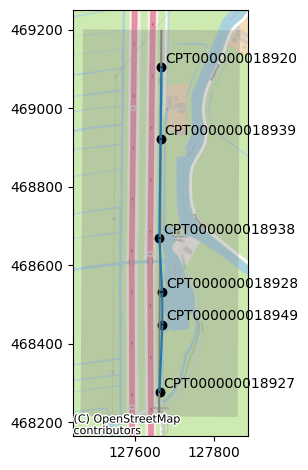

In [10]:
# create a map of the line and CPT's
axis = profile.plot_map(
    add_basemap=True, add_tags=True, tag_type="name", show_all=False
)
plt.savefig("map.png")

In [11]:
# create a profile
fig = profile.plot(
    plot_kwargs={
        "coneResistance": {"line_color": "black", "factor": 2},
        "frictionRatioComputed": {"line_color": "red", "factor": 4},
        "porePressureU2": {"line_color": "blue", "factor": 100},
    },
    hue="uniform",
    fillpattern=False,
    surface_level=False,
    groundwater_level=False,
)
fig.update_layout(title_text=f"{project_name}, classified by {classify_metode}")

Add column to profile: 100%|██████████| 6/6 [00:00<00:00, 40.65it/s]


In [12]:
# html file
_ = plotly.offline.plot(fig, filename=project_number + " " + project_name + ".html")

# png file
# fig.update_layout(showlegend=False)

fig.write_image("profile_A2.png", width=1900, height=937)